# Data loaders

SPCSim provides multiple classes to quickly load or simulate data formats like RGB-D data and transient data.

## RGB-D data

**Example to use `NYULoader1` class from `rgbd_loaders` module of `data_loaders` subpackage**

`NYULoader1` inherits `RGBDLoader` which is the base class used to load RGB-D datasets. `NYULoader1` overwrites the `dist_preproc` method to specify how the distance maps are loaded and preprocessed for the NYUv2 dataset. (TODO: cite NYUv2 dataset)

* Set the path to the NYUv2 dataset and corresponding CSV file
* Set the image resolution for the RGB-D frames
* Access an RGB-D frame using the `get_data` method

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from SPCSim.data_loaders.rgbd_loaders import NYULoader1
from SPCSim.utils.plot_utils import plot_rgbd

csv_file_name = "nyu_data/data/nyu2_train.csv"
root = "nyu_data/"
df = pd.read_csv(csv_file_name, header=None)

# Set the image resolution for the RGB-D frames
nyu_data = NYULoader1(256,256)

idx = 1
rgb_pth = root+df[0][idx]
dist_pth = root+df[1][idx]

# Access an RGB-D frame using the get_data method
data = nyu_data.get_data(rgb_pth, dist_pth, rgb_pth, rgb_pth)

* Using the `plot_rgbd` method from `plot_utils` module of `utils` subpackage.

```
The `plot_utils` module contains a collection of helper functions to plot different data formats
like RGB-D, transient, equi-width histograms, equi-depth histograms, raw-SPC timestamps etc.
```

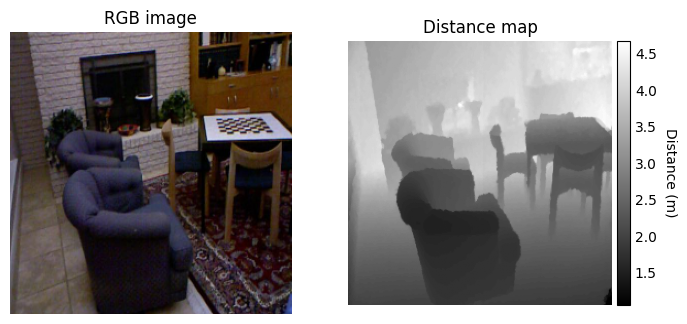

In [4]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

plot_rgbd(fig,
          ax[0],
          ax[1],
          data["rgb"].cpu().numpy(),
          data["gt_dist"].cpu().numpy(),
          show_cbar = True)
plt.show()

---

## Transient data

`NOTE: The TransientGenerator class assumes a single bounce model and does not support multi-bounce scenarios`



**Example to use `TransientGenerator` class from `transient_loaders` module of `data_loaders` subpackage**

This class allows you to generate some quick transients for testing and prototyping. It allows the user to control the active illumination laser properties used in dToF imaging.



In [5]:
from SPCSim.data_loaders.transient_loaders import TransientGenerator
from SPCSim.utils.plot_utils import plot_transient
import matplotlib.pyplot as plt
import torch

Creating transient generator with

* Laser repetition period of 100ns
* Set laser FWHM 1 ns
* With laser time period divided into 1000 equal time-bins


In [6]:
device = "cpu"
tr_gen = TransientGenerator(N_tbins = 1000, tmax = 100, FWHM = 1, device=device)

Setting the scene properties: distance, albedo, signal and background flux

In [7]:
dist_val = torch.tensor([[9.5]], device=device)
albedo = torch.tensor([[1.0]], device=device)
alpha_sig = torch.tensor([[1.0]], device=device)
alpha_bkg = torch.tensor([[2.0]], device=device)

Using the get function to generate the transient for a given distance, albedo, intensity, and illumination condition


Shape of transient image:  torch.Size([1, 1, 1000])
Plot saved as Temp.png ...


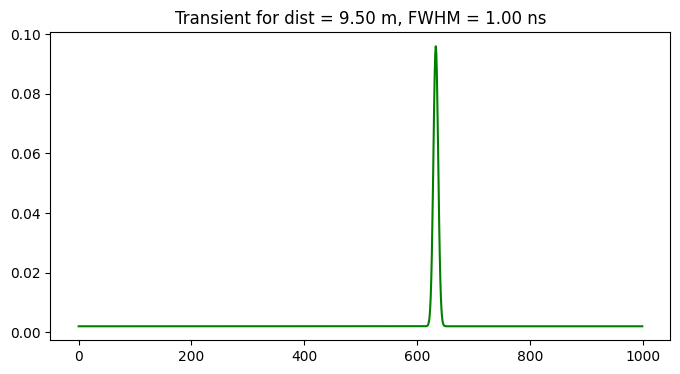

In [8]:
phi_bar = tr_gen.get_transient(dist_val,
                               albedo,
                               albedo,
                               alpha_sig,
                               alpha_bkg)

print("Shape of transient image: ",phi_bar.shape)

fig, ax = plt.subplots(1,1,figsize=(8,4))
plot_transient(ax, phi_bar.cpu().numpy()[0,0,:])
ax.set_title("Transient for dist = %.2f m, FWHM = %.2f ns"%(dist_val[0,0], tr_gen.FWHM))
fig.savefig("Temp.png")

print("Plot saved as Temp.png ...")

---

## Custom multi-pixel data

The `PerPixelLoader` class allows researchers to leverage vectorization and hardware acceleration benefits of PyTorch and simulate single photon camera measurements for different combinations of scene properties simultaneously. Moreover it also allows to simulate multiple runs for each combination of scene properties to generate better experiment statistics and trends.



**Example to use `PerPixelLoader` class from `perpixel_loaders` module of `data_loaders` subpackage**

In this example we will simulate data for
* `num_dist = 3` scene distance values equally spaced between `[0,1.0*Dmax]`
* `sig_bkg_list` 2 illumination conditions, i.e. average (signal, background) flux for each scene distance $[\Phi_{sig},\Phi_{bkg}] \in$ $\{ [1,1], [0.5, 2]\}$
* `num_run = 3` independent runs for each combination of scene distance and illumination conditions.

⛔ `NOTE: Runs do not represent the number of laser cycles per exposure time. It represents number of independent experiments performed for each combination of scene properties.`

In [9]:
from SPCSim.data_loaders.perpixel_loaders import PerPixelLoader
import numpy as np
import matplotlib.pyplot as plt

PixLdr = PerPixelLoader(num_dists = 3,
                        min_dist = 0,
                        max_dist = 1,
                        sig_bkg_list = [
                            [1,1],
                            [0.5,2]
                        ],
                        tmax = 100,
                        num_runs = 3,
                        device = "cpu")


Use the `get_data` method to get the data in form of a dictionary. True distance, signal and background flux can be accesed from the dictionary.

In [10]:

# Generate the per pixel data
data = PixLdr.get_data()

# Output from PerPixelLoader is in form of a dictionary
# Use relevent keys to access specific typ0e of data
gt_dist = data["gt_dist"]


# Extract specific data modality
gt_dist = data["gt_dist"]
alpha_sig = data["alpha_sig"]
alpha_bkg = data["alpha_bkg"]

print("Absolute maximum distance :", PixLdr.dmax)
print("GT dist: ", gt_dist, gt_dist.shape)
print("Note the boradcasted values for illumination conditions for each run and each distance")
print("alpha_sig: ", alpha_sig, alpha_sig.shape)
print("alpha_bkg: ", alpha_bkg, alpha_bkg.shape)

Absolute maximum distance : 15.000000000000002
GT dist:  tensor([[ 0.0000,  0.0000,  0.0000],
        [ 7.5000,  7.5000,  7.5000],
        [15.0000, 15.0000, 15.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 7.5000,  7.5000,  7.5000],
        [15.0000, 15.0000, 15.0000]]) torch.Size([6, 3])
Note the boradcasted values for illumination conditions for each run and each distance
alpha_sig:  tensor([[[1.0000],
         [1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000],
         [1.0000]],

        [[0.5000],
         [0.5000],
         [0.5000]],

        [[0.5000],
         [0.5000],
         [0.5000]],

        [[0.5000],
         [0.5000],
         [0.5000]]]) torch.Size([6, 3, 1])
alpha_bkg:  tensor([[[1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.]],

        [[2.],
         [2.],
         [2.]],

        [[2.],
         [2

The `get_row` method can be used to access specific a data point for given illumination and scene distance form the output data.

The scene albedo, distance, average signal and background flux are all returned as 2D tensors where

* Each row corresponds to a specific combination of scene distance and scene illumination condition
* Each column of that row represents data for an independent run.

For example here we access distance value, alpha_sig and alpha_bkg for the `second` independent run `first` illumination condition and `first` scene distance idx.

In [12]:
print("Data for first SBR conditions and first distance value for second run")
ROW = PixLdr.get_row(sbr_idx =0, dist_idx=0)
RUN = 2

print("Dist = ", data["gt_dist"][ROW, RUN])
print("Alpha sig = ", data["alpha_sig"][ROW, RUN])
print("Alpha bkg = ", data["alpha_bkg"][ROW, RUN])

Data for first SBR conditions and first distance value for second run
Dist =  tensor(0.)
Alpha sig =  tensor([1.])
Alpha bkg =  tensor([1.])


## Custom multi-pixel transient data

Combining `PerpixelLoader` and `TransientGenerator` classes to setup a custom experiment with desired range of distance values, laser characteristics and other simulation parameters.

Multi-pixel data for 5 scene distances and 
2 different illumination conditions per scene 
and 7 independent runs per combination
Shape of transient image:  torch.Size([10, 7, 1000])
Note the distance square fall off... As the distance increases the signal intensity reduces...


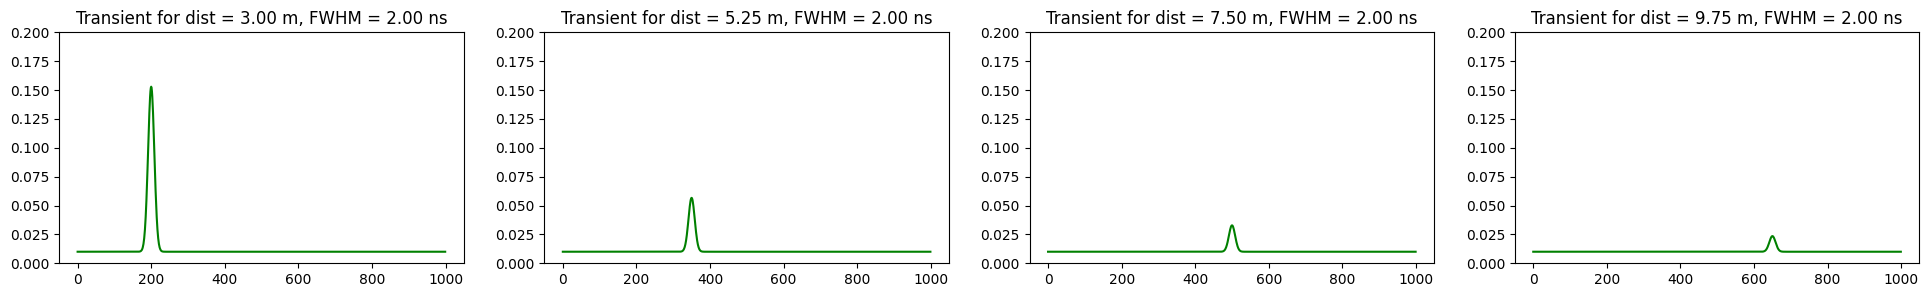

In [17]:
from SPCSim.data_loaders.perpixel_loaders import PerPixelLoader
from SPCSim.data_loaders.transient_loaders import TransientGenerator
from SPCSim.utils import plot_transient

import numpy as np
import matplotlib.pyplot as plt
import torch

# Simulating results for distance = 0.1*dmax
PixLdr = PerPixelLoader(
                        num_dists = 5,
                        min_dist = 0.2,
                        max_dist = 0.8,
                        tmax = 100,
                        num_runs = 7,
                        sig_bkg_list=[
                            [1.0, 1.0],
                            [1.0, 10.0]],
                        device = "cpu")

# Generate the per pixel data
data = PixLdr.get_data()


# Creating transient generator with laser time period of 100ns, FWHM 1 and with
# laser time period divided into 1000 equal time-bins

# NOTE: unlike previous example, here we need to mention the
#       number of rows and cols (Nr, Nc)
tr_gen = TransientGenerator(Nr = PixLdr.Nr,
                            Nc = PixLdr.Nc,
                            N_tbins = 1000,
                            tmax = PixLdr.tmax,
                            FWHM = 2)


# Using the get function to generate the transient
# for a given distance, albedo, intensity, and illumination condition
phi_bar = tr_gen.get_transient(data["gt_dist"],
                               data["albedo"],
                               data["albedo"],
                               data["alpha_sig"],
                               data["alpha_bkg"])

print("Multi-pixel data for 5 scene distances and \n2 different illumination conditions per scene \nand 7 independent runs per combination")
print("Shape of transient image: ",phi_bar.shape)

fig, ax = plt.subplots(1,4,figsize=(24,3))

# Plotting first 4 distances with second SBR condition and second run
ROW = PixLdr.get_row(sbr_idx =1, dist_idx=0)
RUN = 2
plot_transient(ax[0], phi_bar.cpu().numpy()[ROW,RUN,:])
ax[0].set_title("Transient for dist = %.2f m, FWHM = %.2f ns"%(data["gt_dist"][ROW,RUN], tr_gen.FWHM))
ax[0].set_ylim(0, 0.2)

# Plotting first distance and second SBR
ROW = PixLdr.get_row(sbr_idx =1, dist_idx=1)
RUN = 2
plot_transient(ax[1], phi_bar.cpu().numpy()[ROW,RUN,:])
ax[1].set_title("Transient for dist = %.2f m, FWHM = %.2f ns"%(data["gt_dist"][ROW,RUN], tr_gen.FWHM))
ax[1].set_ylim(0, 0.2)

# Plotting second distance and first SBR
ROW = PixLdr.get_row(sbr_idx =1, dist_idx=2)
RUN = 2
plot_transient(ax[2], phi_bar.cpu().numpy()[ROW,RUN,:])
ax[2].set_title("Transient for dist = %.2f m, FWHM = %.2f ns"%(data["gt_dist"][ROW,RUN], tr_gen.FWHM))
ax[2].set_ylim(0, 0.2)

# Plotting second distance and second SBR
ROW = PixLdr.get_row(sbr_idx =1, dist_idx=3)
RUN = 2
plot_transient(ax[3], phi_bar.cpu().numpy()[ROW,RUN,:])
ax[3].set_title("Transient for dist = %.2f m, FWHM = %.2f ns"%(data["gt_dist"][ROW,RUN], tr_gen.FWHM))
ax[3].set_ylim(0, 0.2)

plt.plot()
print("Note the distance square fall off... As the distance increases the signal intensity reduces...")

TODOs:

- [ ] Add detailed description of corresponding data structures